In [1]:
from IPython.display         import SVG
from matplotlib              import pyplot as plt
%config InlineBackend.figure_format = 'retina'

from os                      import makedirs
from os.path                 import exists, isdir

import numpy as np

from sklearn.metrics         import auc, f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import binarize

from keras                   import backend as K
from keras.callbacks         import ProgbarLogger
from keras.layers            import Activation, add, BatchNormalization, Conv1D, Conv2D, Input, Flatten, MaxPool2D, Reshape
from keras.models            import load_model, Model
from keras.utils.vis_utils   import model_to_dot

Using TensorFlow backend.


# Dataset Structure (4 parts)
First goes __*MAPS*__ dataset, with the following structure for each recording rooms and instrument:
##### Loss may become NaN:
`[:9]     176 - Chromatic scale`<br>
`[9:273]   1   - One note` __*NOTE:*__ actual indices below may be slightly less when some samples are excluded (currently, all indices are correct).<br>
`[273:339] 15  - Repeat`<br>
`[339:603] 1   - Stackato`<br>
`[603:735] 30  - Tremolo`

##### Gradients are always Ok:
`[735:765]  inf - Mus`<br>
`[765:3_736] 1  - Chords`

`[3_736 : 3_736 + 9] - Chromatic scale`
<br>--//-- for 9 __*MAPS*__ parts except part 8 (__*SptkBGCl*__) which contains just 30 __*MUS*__ series.

Then go datasets with just "Mus" series for:<br>
`[408_416 : 408_416 + 103_928]` - __*AudioLabs-Erlangen*__<br>
`[-11_366 - 5_253 : -5_253]` - __*LabRosa Columbia*__<br>
`[-5_253 :]` - __*Vienna 4x22 corpus (Aligned)*__

In [2]:
cqts, notes = map(np.load, ['Datasets/{} 529417.npy'.format(name) for name in ['Cqts Float16', 'Notes']]) # All four
#cqts, notes = map(lambda cn: cn[-103_928 - 11_366 - 5_253 : -11_366 - 5_253], [cqts, notes]) # Erlangen
#cqts, notes = map(lambda cn: cn[-11_366 - 5_253 : -5_253], [cqts, notes]) # LabRosa
#cqts, notes = map(lambda cn: cn[-5_253:], [cqts, notes]) # Vienna
assert cqts.min() == 0 and 20 < cqts.mean() < 40 and 70 < cqts.max() < 100
print(len(notes), 'chords,', end='\t')

cqtsTrain, cqtsTest, notesTrain, notesTest = train_test_split(cqts, notes, random_state=42)
print('Cqt decibels in range [{:.1e} - {:.0f} - {:.0f}]'.format(cqts.min(), cqts.mean(), cqts.max()))

529417 chords,	Cqt decibels in range [0.0e+00 - 27 - 93]


# Accuracy Metric (stricter than F1-score):
http://c4dm.eecs.qmul.ac.uk/ismir15-amt-tutorial/AMT_tutorial_ISMIR_2015.pdf<br>Page 50, Slide 100, Evaluation Metric 3 [Dixon, 2000]:
### $$Acc = \frac{\sum_{n}Ntp[n]}{\sum_{n}Nfp[n] + \sum_{n}Nfn[n] + \sum_{n}Ntp[n]} =$$
### $$= \frac{tp}{fp + fn + tp} = \frac{tp}{(pp-tp) + (rp-tp) + tp} = \frac{tp}{pp + rp - tp}$$

In [3]:
def Dixon(yTrue, yPred):
    # true (correct) positives, predicted positives = tp + fp, real (ground-truth) positives = tp + fn
    tp, pp, rp = K.sum(yTrue * K.round(yPred)), K.sum(K.round(yPred)), K.sum(yTrue)
    return 1 if pp == 0 and rp == 0 else tp / (pp + rp - tp + K.epsilon())

batchSize, modelFolder = 2_048, 'Models' # HDF5-files

# CNN Model, Option 1
I used the forward skip connections (__*"ResNet"*__) similar to the left variant (called __*"bottle neck"*__) from the figure below:

![](https://cdn-images-1.medium.com/max/1600/1*7JzJ1RGh1Y4VoG1M4dseTw.png 'ResNets')
With the variant from the right each epoch took too much time, and I did not have patience to wait.

From https://arxiv.org/pdf/1508.01774.pdf (Page 8, D. Network Training, 3) ConvNet Acoustic Models):
1. *"Although pooling can be performed along both axes, we only perform pooling over the frequency axis."*<br>
2. *"Dropout with rate 0.5 is applied to all convolutional layers."*
3. *"0.5 Dropout was applied to all the fully connected layers."*

In [4]:
def CreateModel_Unused():
    from keras.layers import Dense, Dropout, Lambda, MaxPool1D, Permute, ZeroPadding1D

    BnRelu = lambda x: Activation('relu')(BatchNormalization()(x))
    ReshapeHarmonics = lambda x, nFilters: Permute((3, 2, 1))(Reshape((nFilters, int(x.shape[2] * x.shape[3]) // nFilters,
                                                                       cqts.shape[1]))(Permute((3, 2, 1))(x)))
    def BottleNeck(x, nFilters, ConvFunc):
        ConvBlock = lambda nFilters, kernel, x: Dropout(.5)(ConvFunc(nFilters, kernel, padding='same')(BnRelu(x)))
        return add([x, ConvBlock(nFilters, 1, ConvBlock(int(np.ceil(nFilters / 4)), 3,
                                              ConvBlock(int(np.ceil(nFilters / 4)), 1, x)))])
    def BottleNeck1D(x):
        assert x.shape[2] == cqts.shape[1]
        return BottleNeck(x, int(x.shape[2]), Conv1D)
    def BottleNeck2D(x):
        return BottleNeck(x, int(x.shape[3]), Conv2D)

    inputs, nBins = Input(shape=(cqts.shape[1], cqts.shape[2])), cqts.shape[2] // notes.shape[1]
    resSum = BottleNeck1D(Permute((2, 1))(BatchNormalization()(inputs)))
    resSum = Reshape((cqts.shape[1], 12 * nBins * 8, 1))(Permute((2, 1))(
        ZeroPadding1D((-cqts.shape[2] % (12 * nBins), 0))(resSum)))

    '''There are no harmonics beyond second octave:
    1st harmonic lies 12 notes apart, 2nd - 6 notes apart, 3rd - 3 notes = 6 + 3 = 9, 4th = 9 + 1.5 = 10.5,
    5th = 10.5 + 0.75 = 11.25, 6th = 11.25 + 0.375 = 11.625, 7th = 11.625 + 0.1875 = 11.8125, etc.
    So, immediately reshape to the length of one octave:'''
    resSum = BottleNeck2D(ReshapeHarmonics(resSum, 8))
    # The first filter will be completely from our zero-padding above, so Lambda will discard it:
    resSum = BottleNeck2D(Lambda(lambda x: x[:, :, :, 1:])(ReshapeHarmonics(resSum, 16)))
    resSum = BottleNeck2D(ReshapeHarmonics(resSum, 30))

    assert nBins == 4, ("Number of cqt bins != 4, so can't reshape to nBins * 1.5 & nBins * 0.75"
                        "Correct or remove the corresponding two residual blocks below")
    # Lambda will discard another temporary filter again:
    resSum = BottleNeck2D(Lambda(lambda x: x[:, :, :, 1:])(ReshapeHarmonics(resSum, 60)))
    resSum = BottleNeck2D(ReshapeHarmonics(resSum, 59 * 2))
    # Remaining two "zero"-columns:
    resSum = Lambda(lambda x: x[:, :, :, 2:])(ReshapeHarmonics(resSum, 59 * 2 * 3))
    assert resSum.shape[3] == cqts.shape[2]
    
    # Now we can reduce the frequency axis, since we have captured high harmonics which lie close to each other:
    resSum = MaxPool1D(nBins)(Permute((2, 1))(Reshape((int(resSum.shape[1]), int(resSum.shape[3])))(resSum)))

    resSum = Flatten()(BottleNeck1D(resSum))
    resSum = add([resSum, Dropout(.5)(Dense(cqts.shape[1] * notes.shape[1])(BnRelu(
                          Dropout(.5)(Dense(cqts.shape[1] * notes.shape[1])(BnRelu(resSum))))))])
    
    return Model(inputs, Dense(notes.shape[1], activation='sigmoid')(BnRelu(resSum)))

# CNN Model, Option 2
Previous model is not bad, it just contains Keras __*"Permute"*__ layers which are currently not supported by __*"Frugally Deep"*__ Keras to C++ convertor (will be used in the end of this template).  To call that model predictions from C++, one would have to split the model in several parts and reshape tensors in between in C++ manually.

So, here is "Option 2", which can be straightforwardly converted to C++. The idea is entirely based on the algorithm explanation of the following commercial software:<br>
https://www.lunaverus.com/cnn
1. *"... there's no need for fully connected layers and the CNN can be made entirely of convolutional and max pooling layers."*
2. *"... many of the convolutions long and skinny."*
3. *"... Most of the network consisted of pairs of layers: an Mx1 followed by a 1xN.  These long convolutions helped efficiently connect distant regions of the spectrum.*"

So, it is just plain __*"ResNet"*__ layers, but with huge filter sizes which would cover all harmonics of interest. It would probably be better to use smaller filters and more layers (current trend for __*"ResNet"*__ models and image recognition).  Not sure if it would be applicable for audio transcription, but in this case model trains much slower anyway.  So, again, I did not have patience to wait and used short and wide __*"ResNet"*__.

Surprisingly, there is no sign of overfitting in this model, and dropout is not required at all.  Also, since it is __*"ResNet"*__, and it should not become worse with the more number of layers, I repeated each residual block *"nResBlocks"* number of times.  I tried *"nResBlocks"* = 1, 2, 5, 10, 11, and sticked to 5 as a compromise between accuracy and speed.  However, I could have missed optimal number in between (__*TODO*__: try *"nResBlocks"* = 3, 4 and 6, 7, 8, 9).  *"nResBlocks"* = 1 and 2 is obviously not enough, and on the other hand, for *"nResBlocks"* = 10 and 11 there is not much of improvement, plus, validation accuracy fluctuates more (maybe due to reduced batch size).

In [5]:
nResBlocks = 5
def CreateModel():
    BnRelu = lambda x: Activation('relu')(BatchNormalization()(x))
    ResNet = lambda x, freqBand: add([x, Conv2D(1, (      1,    freqBand), padding='same')(BnRelu(
                                         Conv2D(1, (K.int_shape(x)[1], 1), padding='same')(BnRelu(x))))])

    inputs = Input(shape=(cqts.shape[1], cqts.shape[2]))
    resSum = Reshape((cqts.shape[1], cqts.shape[2], 1))(BatchNormalization()(inputs))
    
    ''''There are no harmonics beyond second octave (see explanation in the model option 1).
    Two octaves = 2 * 12 notes * 4 cqt bins = 96 bins. Conv filter is centered, so to cover this range,
    need filter size twice larger = 96 one way + 96 the other + central node = 193. Let's have 201, just in case:'''
    for _ in range(nResBlocks): resSum = ResNet(resSum, 201)
    resSum = MaxPool2D((1, 2))(resSum)                       # Reduce the frequency axis by half
    for _ in range(nResBlocks): resSum = ResNet(resSum, 101) # Filter size also reduced by half
    resSum = MaxPool2D((1, 2))(resSum)                       # Again, and now we have 88 frequencies = number of notes
    for _ in range(nResBlocks): resSum = ResNet(resSum, 51)  # -- // -- filter size reduced
    
    resSum = MaxPool2D((3, 1), strides=1)(resSum)            # Reduce the time axis from 7 to 5
    for _ in range(nResBlocks): resSum = ResNet(resSum, 51)
    resSum = MaxPool2D((3, 1), strides=1)(resSum)            # Again, from 5 to 3
    for _ in range(nResBlocks): resSum = ResNet(resSum, 51)
    
    resSum = Reshape((notes.shape[1], 1))(MaxPool2D((3, 1))(resSum)) # Again, from 3 to 1, and 1D-ResNet:
    for _ in range(nResBlocks): resSum = add([resSum, Conv1D(1, 51, padding='same')(BnRelu(
                                                      Conv1D(1, 51, padding='same')(BnRelu(resSum))))])
    
    return Model(inputs, Activation('sigmoid')(Flatten()(resSum)))  # No need for fully-connected layer (prevent overfitting)

Loading pre-trained model...
Spent 51 epochs, current validation loss and Dixon are:
132355/132355 [==============================] - 201s 2ms/step
[2.601222407296798, 0.6049816585975043]


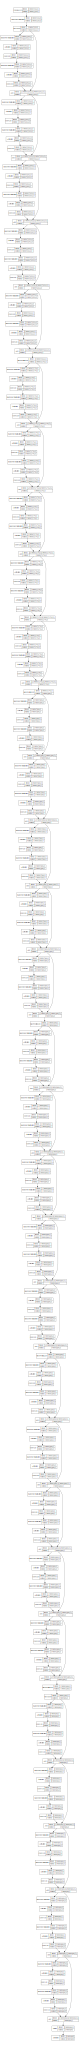

In [6]:
evalBatchSize = 8_192

if not isdir(modelFolder): makedirs(modelFolder)
model = hist = None
if exists(modelFolder + '/Training Model.hdf5') and exists(modelFolder + '/Training History.npy'):
    hist = np.load(modelFolder + '/Training History.npy')[0]
    print('Loading pre-trained model...')
    model = load_model(modelFolder + '/Training Model.hdf5', {'Dixon': Dixon})
    print('Spent', len(hist['loss']), 'epochs, current validation loss and Dixon are:')
    print(model.evaluate(cqtsTest, notesTest, evalBatchSize, 1))

elif not exists(modelFolder + '/Training Model.hdf5') and not exists(modelFolder + '/Training History.npy'):
    model = CreateModel()
    model.compile('Adam', 'categorical_crossentropy', [Dixon])

else: assert False, 'Either provide both training model & training history files, or none'

SVG(model_to_dot(model, True, False).create(format='svg'))

# 1. Training.

In [11]:
class ValDixon_ProgbarLogger(ProgbarLogger):
    def __init__(self):
        super().__init__()
        self.verbose = 1 # ignore the argument from fit()

    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.params['metrics'].remove('val_loss')

# To print the 1st line with the number of train/validate samples, and to init history dict:
newHist = model.fit(cqtsTrain, notesTrain, batchSize, 0 if hist else 1, validation_data=(cqtsTest, notesTest)).history
if not hist: hist = newHist
loss, dixonTrain, dixonVal = np.inf, hist['Dixon'][-1], hist['val_Dixon'][-1]
while loss > hist['loss'][-1]:
    loss, newHist = hist['loss'][-1], model.fit(cqtsTrain, notesTrain, batchSize, 1, 0, callbacks=[
        ValDixon_ProgbarLogger()], validation_data=(cqtsTest, notesTest)).history
    hist = {key: hist[key] + val for key, val in newHist.items()}
    if dixonTrain < hist['Dixon'][-1] and dixonVal < hist['val_Dixon'][-1]:
        dixonTrain, dixonVal = hist['Dixon'][-1], hist['val_Dixon'][-1]
        np.save('{}/Training History {} {:.2f} {:.2f}'.format(
            modelFolder, nResBlocks, hist['Dixon'][-1] * 100, hist['val_Dixon'][-1] * 100), [hist])
        model.save('{}/Training Model {} {:.2f} {:.2f}.hdf5'.format(
            modelFolder, nResBlocks, hist['Dixon'][-1] * 100, hist['val_Dixon'][-1] * 100))

Train on 397062 samples, validate on 132355 samples
Epoch 1/1
397062/397062 [==============================] - 1694s 4ms/step - loss: 2.5998 - Dixon: 0.6127 - val_Dixon: 0.6075
Epoch 1/1
397062/397062 [==============================] - 1636s 4ms/step - loss: 2.5975 - Dixon: 0.6134 - val_Dixon: 0.6164
Epoch 1/1
397062/397062 [==============================] - 1640s 4ms/step - loss: 2.5965 - Dixon: 0.6131 - val_Dixon: 0.6177
Epoch 1/1
397062/397062 [==============================] - 1665s 4ms/step - loss: 2.5950 - Dixon: 0.6135 - val_Dixon: 0.6109
Epoch 1/1
397062/397062 [==============================] - 1637s 4ms/step - loss: 2.5943 - Dixon: 0.6134 - val_Dixon: 0.6074
Epoch 1/1
397062/397062 [==============================] - 1649s 4ms/step - loss: 2.5942 - Dixon: 0.6133 - val_Dixon: 0.6072
Epoch 1/1
397062/397062 [==============================] - 1635s 4ms/step - loss: 2.5929 - Dixon: 0.6133 - val_Dixon: 0.6163
Epoch 1/1
397062/397062 [==============================] - 1633s 4ms/step

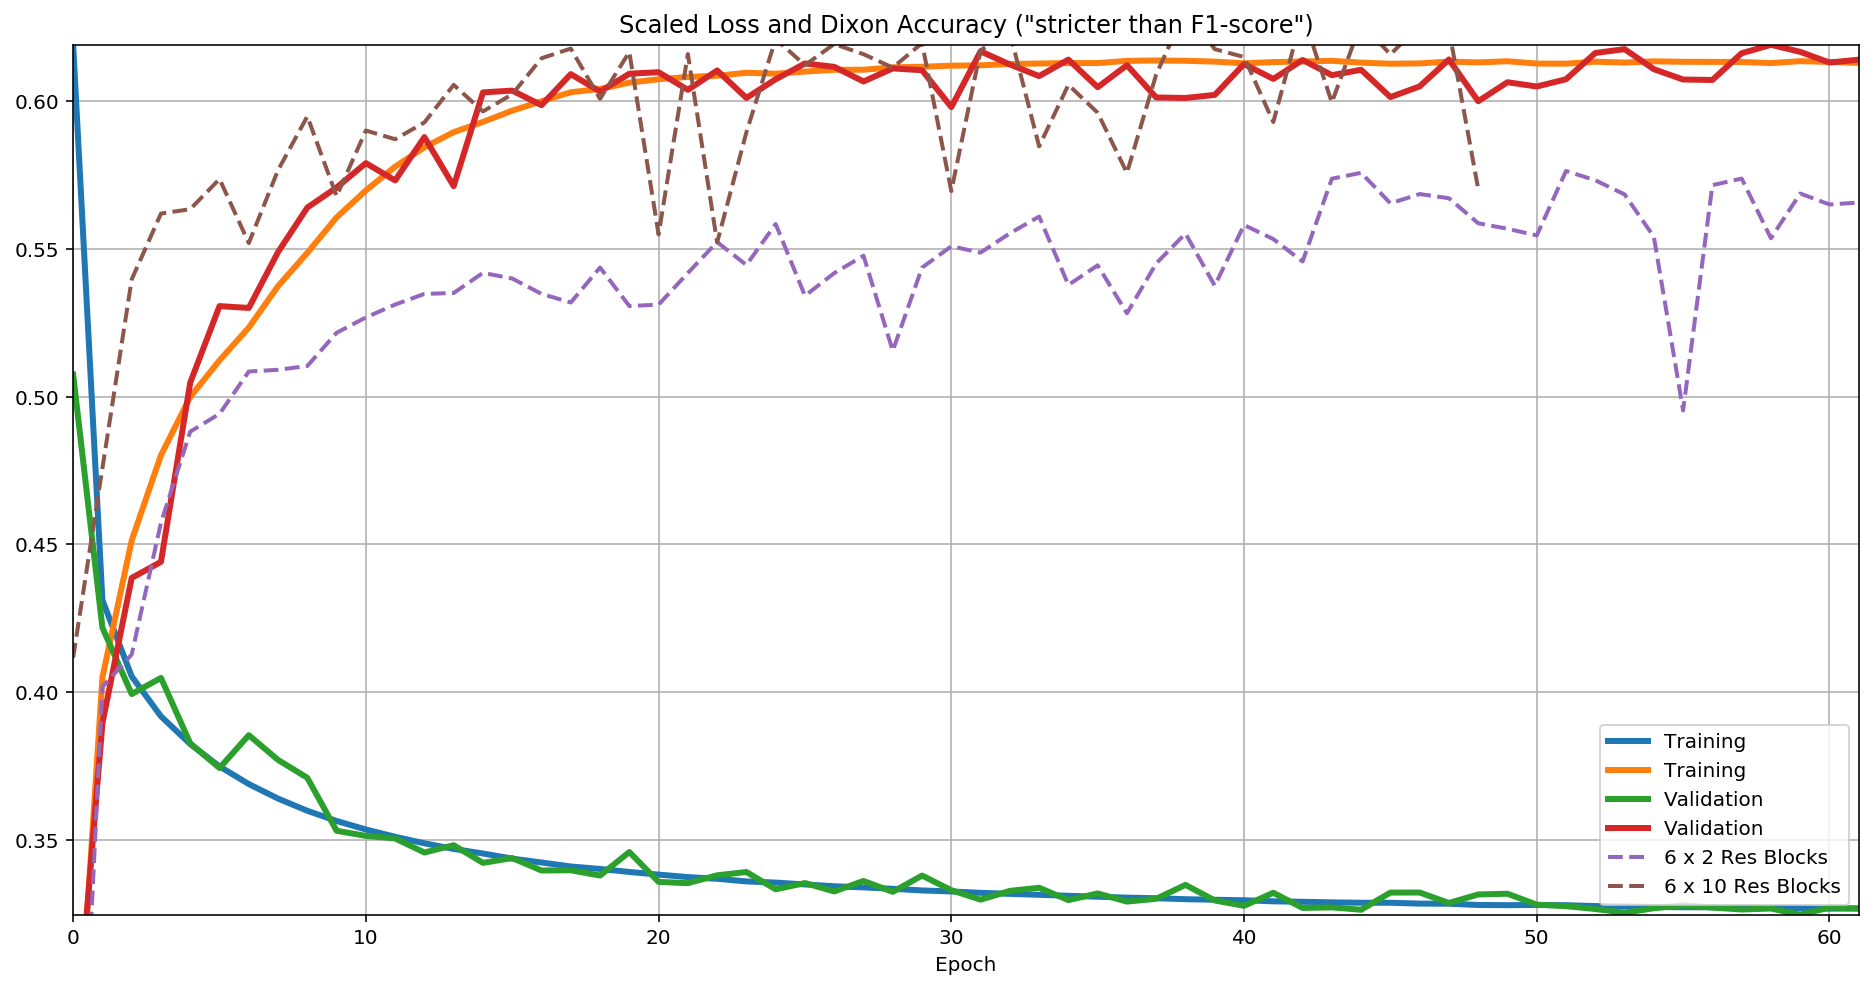

In [15]:
plt.figure(figsize=(16, 8))

maxDixon  = max(hist['Dixon'] + hist['val_Dixon'])
lossScale = max(hist['loss']  + hist['val_loss']) / maxDixon

plt.plot(hist[     'loss'] / lossScale, linewidth=3, label='Training')
plt.plot(hist[    'Dixon'],             linewidth=3, label='Training')
plt.plot(hist[ 'val_loss'] / lossScale, linewidth=3, label='Validation')
plt.plot(hist['val_Dixon'],             linewidth=3, label='Validation')
plt.plot(np.load(modelFolder + '/Training History 2 56.17 54.46.npy')[0]['val_Dixon'],
                                  '--', linewidth=2, label='6 x 2 Res Blocks')
plt.plot(np.load(modelFolder + '/Training History 10 62.65 57.04.npy')[0]['val_Dixon'],
                                  '--', linewidth=2, label='6 x 10 Res Blocks')
plt.legend()

plt.title('Scaled Loss and Dixon Accuracy ("stricter than F1-score")')
plt.xlabel('Epoch')
plt.xlim(0, len(hist['loss']) - 1)
plt.ylim(min(hist['loss'] + hist['val_loss']) / lossScale, maxDixon)
plt.grid()

# 2. Validation.

In [16]:
yProb = model.predict(cqtsTest, evalBatchSize, 1)
assert 0 < yProb.min() < 1e-6 and 1 - 1e-6 < yProb.max() <= 1

yPred = binarize(yProb, .5).astype(int)
print('\nJust out of cuiosity, some other macro-averaged accuracy metrics:\n'
      'Precision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}'.format(
          precision_score(notesTest, yPred, average='macro'), recall_score(notesTest, yPred, average='macro'),
          f1_score(notesTest, yPred, average='macro')))
      
numNotesTrue, numNotesPred = notesTest.sum(1).mean(), yProb.mean() * 88
print('\nActual and predicted average number of notes: {:.1f} {:.1f}'.format(numNotesTrue, numNotesPred))
print('Predicts',                'more' if numNotesPred > numNotesTrue else 'less',
      'notes than actual', '(sensitive' if numNotesPred > numNotesTrue else '(specific', 'classifier)')
assert abs(numNotesTrue - numNotesPred) < .5
'Ok.'

132355/132355 [==============================] - 178s 1ms/step

Just out of cuiosity, some other macro-averaged accuracy metrics:
Precision (specificity) = 81.39%
Recall    (sensitivity) = 68.48%
F1-score                = 73.42%

Actual and predicted average number of notes: 1.8 2.0
Predicts more notes than actual (sensitive classifier)


'Ok.'

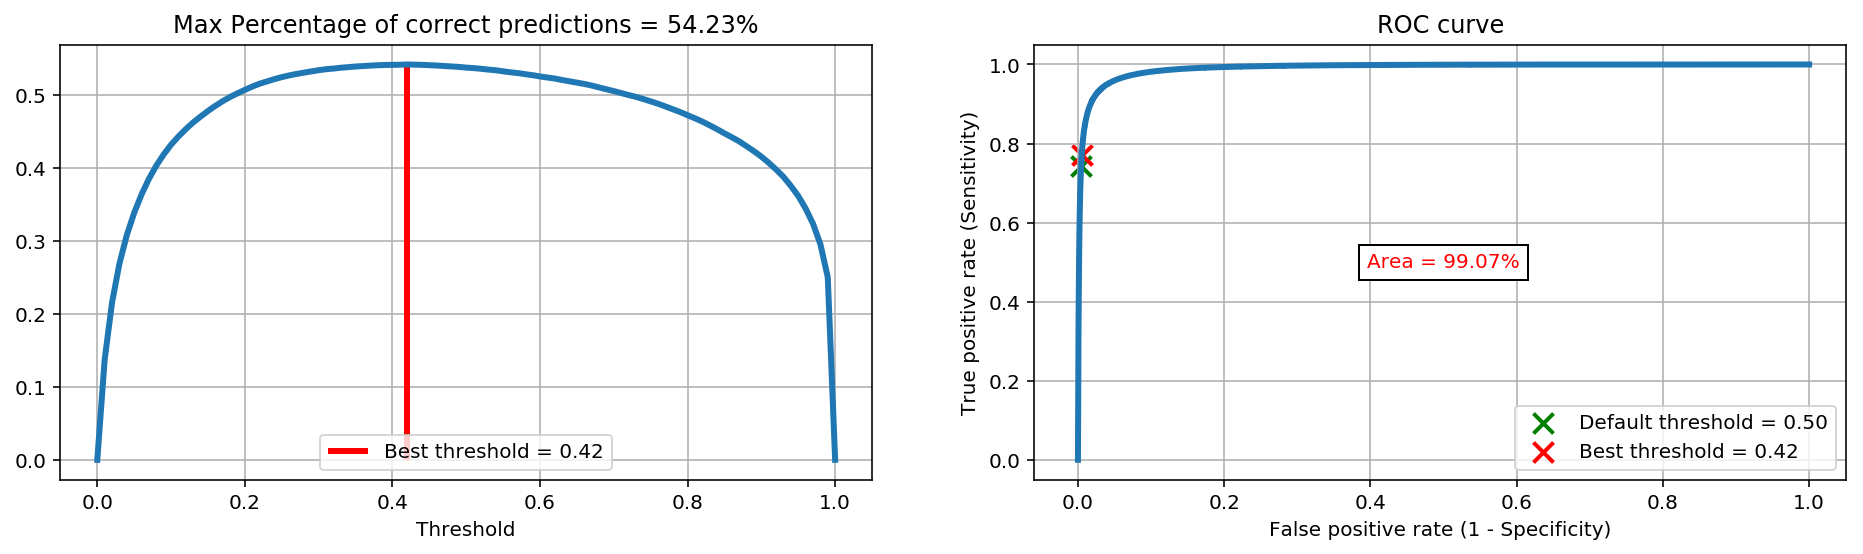

In [17]:
FrameAccuracy = lambda y: (notesTest == y).all(1).mean()

precision = 100
th = [i / precision for i in range(precision + 1)]
acc = [FrameAccuracy(binarize(yProb, t)) for t in th]

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)

plt.plot(th, acc, linewidth=3)
plt.title('Max Percentage of correct predictions = {:.2%}'.format(max(acc)))
plt.xlabel('Threshold')

thBest = acc.index(max(acc)) / precision
plt.vlines(thBest, 0, max(acc), 'r', label='Best threshold = ' + str(thBest), linewidth=3)

plt.legend()
plt.grid()


plt.subplot(1, 2, 2)

fpr, tpr, ths = roc_curve(notesTest.ravel(), yProb.ravel()) # micro-average ROC curve
plt.plot(fpr, tpr, linewidth = 3)

plt.title('ROC curve')
plt.xlabel('False positive rate (1 - Specificity)')
plt.ylabel('True positive rate (Sensitivity)')

plt.scatter(fpr[ths > .5][-1], tpr[ths > .5][-1], s=100, c='g', marker='x',
            linewidth=2, label='Default threshold = 0.50')
plt.scatter(fpr[ths > thBest][-1], tpr[ths > thBest][-1], s=100, c='r', marker='x',
            linewidth=2, label='Best threshold = ' + str(thBest))

plt.legend()
plt.grid()
plt.text(.5, .5, 'Area = {:.2%}'.format(auc(fpr, tpr)), horizontalalignment='center', verticalalignment='center',
         bbox={'facecolor': 'w', 'alpha': 1}, color='r'); # micro-average area under the ROC curve

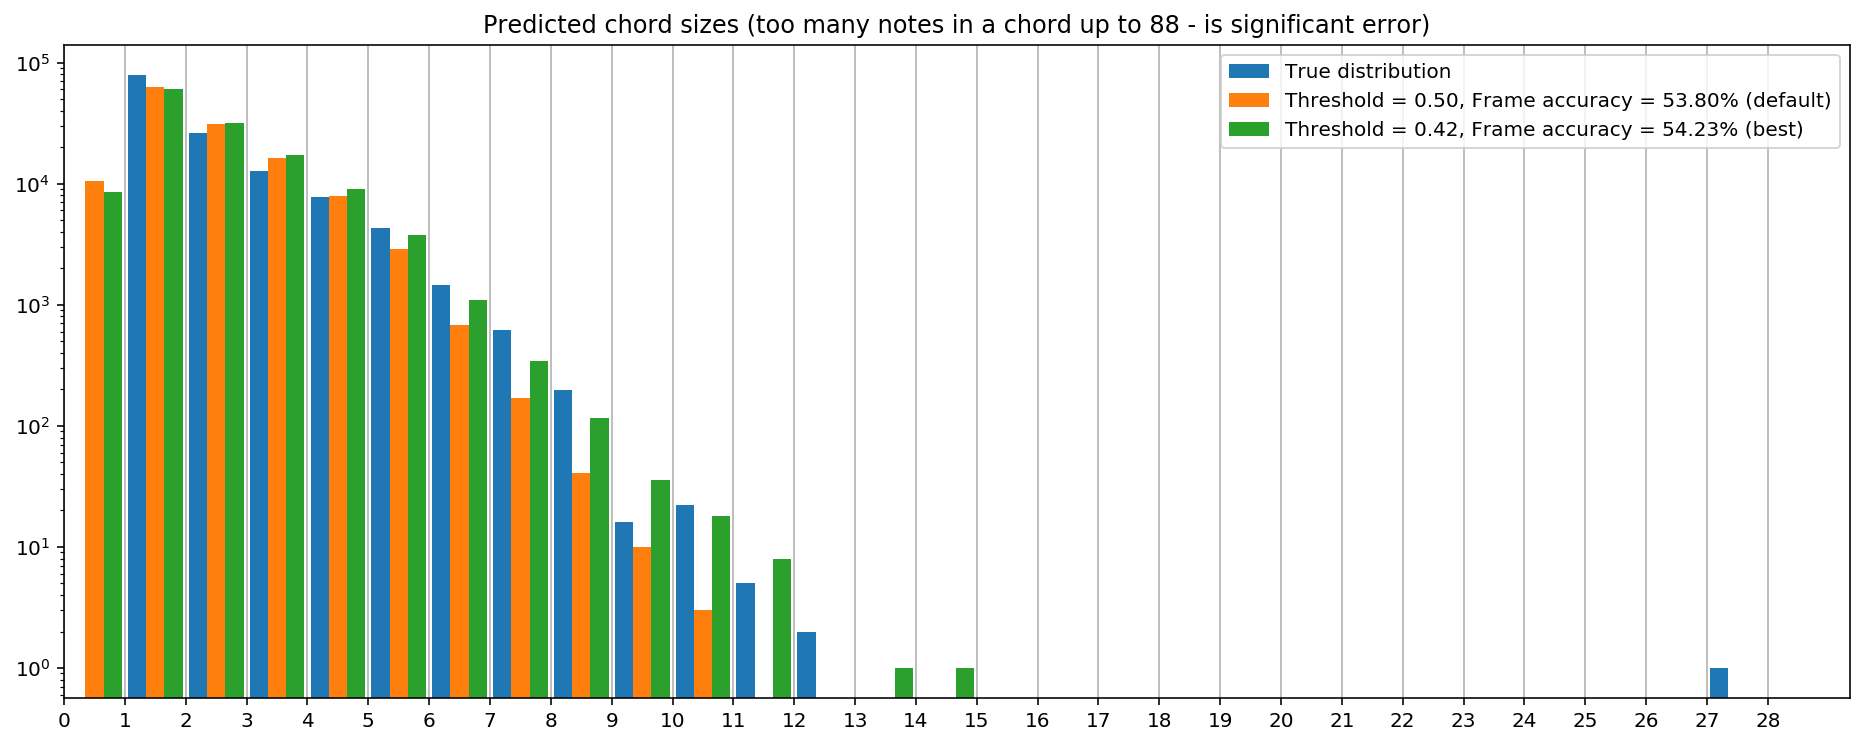

In [18]:
yPresize = binarize(yProb, thBest).astype(int)
counts = [notesTest.sum(1), yPred.sum(1), yPresize.sum(1)]
maxCount = np.max(counts)

plt.figure(figsize=(16, 6))
plt.hist(counts, maxCount, rwidth=.9, log=True, label=['True distribution',
    'Threshold = 0.50, Frame accuracy = {:.2%} (default)'.format(        FrameAccuracy(yPred)),
      'Threshold = {}, Frame accuracy = {:.2%} (best)'   .format(thBest, FrameAccuracy(yPresize))])

plt.title('Predicted chord sizes (too many notes in a chord up to 88 - is significant error)')
plt.xlim(0)
plt.xticks(range(maxCount + 1))
plt.grid(axis='x')
plt.legend();

# 3. Final Training on Full Dataset.

In [33]:
finalModel = finalHist = None
if exists(modelFolder + '/Final Model.hdf5') and exists(modelFolder + '/Final History.npy'):
    finalHist = np.load(modelFolder + '/Final History.npy')[0]
    print('Loading pre-trained final model...')
    finalModel = load_model(modelFolder + '/Final Model.hdf5', {'Dixon': Dixon})

elif not exists(modelFolder + '/Final Model.hdf5') and not exists(modelFolder + '/Final History.npy'):
    finalHist, finalModel = {'loss': hist['loss'][-1:], 'Dixon': hist['Dixon'][-1:]}, model

else: assert False, 'Either provide both final model & final history files, or none'

print('Spent', len(finalHist['loss']) - 1, 'epochs after validating.')

Loading pre-trained final model...
Spent 27 epochs after validating.


In [31]:
loss = np.inf
while loss > finalHist['loss'][-1]:
    loss, newHist = finalHist['loss'][-1], finalModel.fit(cqts, notes, batchSize, 1).history
    finalHist = {key: finalHist[key] + val for key, val in newHist.items()}
    np.save(      '{}/Final History {:.2f} 61 54'.     format(modelFolder, finalHist['Dixon'][-1] * 100), [finalHist])
    finalModel.save('{}/Final Model {:.2f} 61 54.hdf5'.format(modelFolder, finalHist['Dixon'][-1] * 100))

Epoch 1/1
529417/529417 [==============================] - 1947s 4ms/step - loss: 2.5699 - Dixon: 0.6138
Epoch 1/1
529417/529417 [==============================] - 1943s 4ms/step - loss: 2.5685 - Dixon: 0.6141
Epoch 1/1
529417/529417 [==============================] - 1947s 4ms/step - loss: 2.5674 - Dixon: 0.6144
Epoch 1/1
529417/529417 [==============================] - 1945s 4ms/step - loss: 2.5676 - Dixon: 0.6143


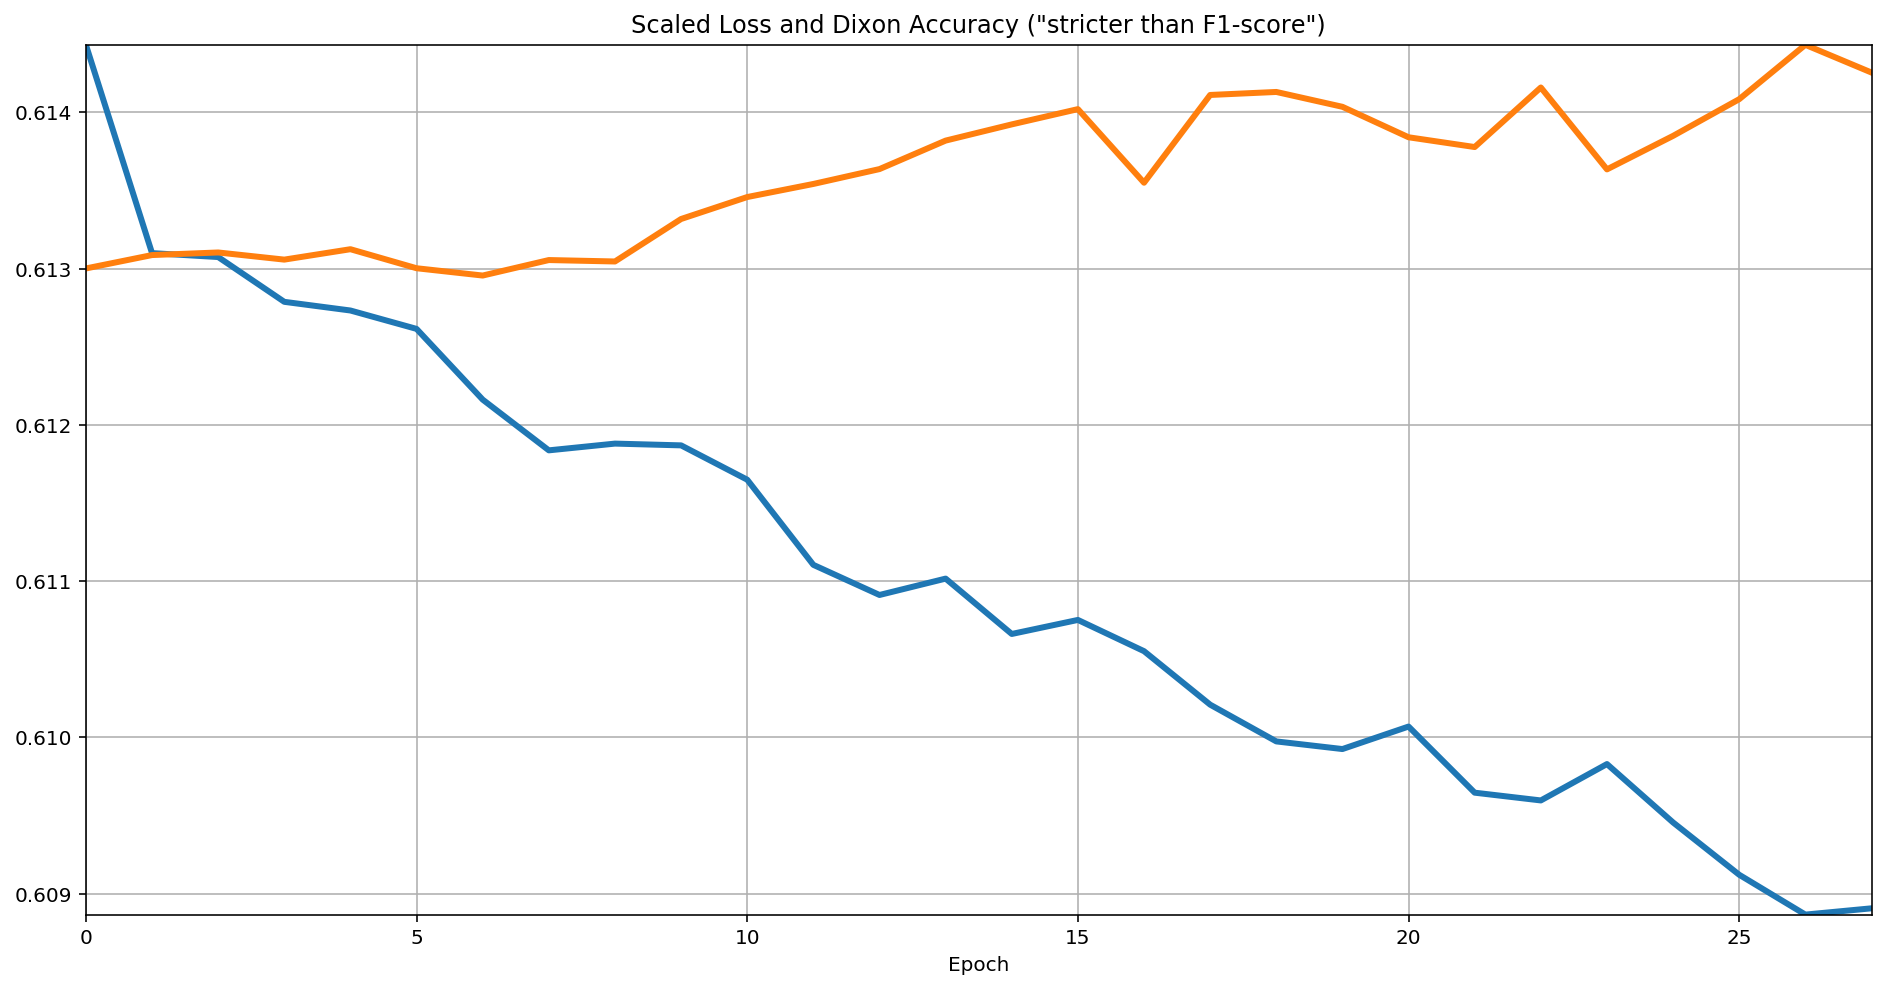

In [32]:
plt.figure(figsize=(16, 8))

maxDixon  = max(finalHist['Dixon'])
lossScale = max(finalHist['loss']) / maxDixon

plt.plot(range(len(finalHist['loss'])),  finalHist['loss'] / lossScale, linewidth=3)
plt.plot(range(len(finalHist['Dixon'])), finalHist['Dixon'],            linewidth=3)

plt.title('Scaled Loss and Dixon Accuracy ("stricter than F1-score")')
plt.xlabel('Epoch')
plt.xlim(0, len(finalHist['loss']) - 1)
plt.ylim(   min(finalHist['loss']) / lossScale, maxDixon)
plt.grid()

# Keras model HDF5-file to JSON conversion<br>(without optimizer, for using just forward-pass predictions in C++):
https://github.com/Dobiasd/frugally-deep/tree/master/keras_export

In [34]:
finalModel.save('Model Dixon{:.0f} Frame54.hdf5'.format(finalHist['Dixon'][-1] * 100), include_optimizer=False)
%run convert_model.py "Model Dixon61 Frame54.hdf5" "KerasModel Dixon61 Frame54.json"

loading Model Dixon61 Frame54.hdf5


C:\Anaconda3\lib\site-packages\keras\engine\saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Forward pass took 4.978329 s.
Forward pass took 0.015626 s.
Forward pass took 0.015624 s.
Starting performance measurements.
Forward pass took 0.03125 s.
Forward pass took 0.015626 s.
Forward pass took 0.01564 s.
Forward pass took 0.024243 s.
Forward pass took 0.015636 s.
Forward pass took 0.020479 s on average.
writing KerasModel Dixon61 Frame54.json
